In [1]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
from astropy.convolution import Gaussian1DKernel
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


# Part 1: Updates

In [1]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy

'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

S
^C


'\n\n\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git\n!py -m pip install reproject\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git \n!py -m pip install pyspeckit\n!py -m pip install regions\n!py -m pip install astrodendro\n!py -m pip  install wcsaxes \n!py -m pip  install ipympl\n!py -m pip install dask\n!py -m pip install radio_beam\n!py -m pip install casa_formats_io\n#try:\n#    !pip install casa_formats_io --no-binary :all:\n#except:\n#    !pip install casa_formats_io --no-cache --no-binary :all:\n\n!py -m pip  install spectral_cube \n!py -m pip  install typing \n!py -m pip install mypy\n!py -m pip  install typing_extensions \n'

# Part 2: Reprojection

In [11]:

#Just Using CO 3-2 right now
files = ["NGC253.band7.TP+12m-mid+12m-high.CO_3-2.image.pbcor.fits"]
#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [140,800]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
for i in range(0,300):
    
    sc = SpectralCube.read(files[0])  
    
    if(i*30>len(sc)):
        print("End Loop at",i)
        break

    sc = sc[i*30:i*30+30,50:np.shape(sc)[1]-50,50:np.shape(sc)[2]-50]# Make a subcube
    #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
    #Put in the right system
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    del sc

    sc = sc_kms.spectral_slab(0. *u.km / u.s, 501. *u.km / u.s)  # Crop out velocities we don't care about    
    del sc_kms
    sc.allow_huge_operations=True    
    HI = sc.header
    Nres=3*u.pc
    dist=3.5*10**6
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
    sc.allow_huge_operations=True
    sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
    

   
    gal="NGC253"
    
    
    
    #Now that we have a circular beam, this can be done easily:
    #use some trig to make a rectangle at 33 deg, and allow pixels inside it.
    if(gal == 'NGC253'):

        cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
        cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
        #center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
        center = SkyCoord('00h47m33.14s' ,'-25d17m17.52s',frame='icrs')
        
        center_ra_pix,center_dec_pix = [int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])]
        PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*3.5*10**6))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*3.5*10**6))/2]
        print(center_ra_pix,center_dec_pix)
        pixels = np.zeros(np.shape(sc))           
        for lmi in range(np.shape(sc)[0]):
            for lmj in range(np.shape(sc)[1]):
                for lmk in range(np.shape(sc)[2]):
                    hypo = np.sqrt(((lmj-center_dec_pix)**2) + (lmk-center_ra_pix)**2)

                    if (lmj-center_dec_pix!=0):
                        ang = np.arctan(abs(lmk-center_ra_pix)/abs(lmj-center_dec_pix))#Find angle to the center
                    else:
                        ang = np.pi/2
                    if(lmk>center_ra_pix and lmj>center_dec_pix):
                        ang*=-1
                        #print("A",lmk,lmj,ang)
                    elif(lmk<center_ra_pix and lmj<center_dec_pix):
                        ang*=-1
                        #print("B",lmk,lmj,ang)
                    elif(lmk>center_ra_pix and lmj<center_dec_pix):
                        if ang >57*np.pi/180:
                            #print("C",lmk,lmj,ang)
                            
                            ang= -33*np.pi/180+147*np.pi/180-ang#coming from the opposite end of the ra axis now, but projecting still to 33 deg from north.
                            
                            #print(ang,hypo*np.cos(abs((33*np.pi/180)+ang)),hypo*np.sin(abs((33*np.pi/180)+ang)))
                        else:
                            #print(ang,hypo*np.cos(abs((33*np.pi/180)+ang)),hypo*np.sin(abs((33*np.pi/180)+ang)))
                            #print("D",lmk,lmj,ang)
                            pass
                            
                        
                    up_pixels = abs(hypo*np.cos(abs((33*np.pi/180)+ang)))#Should not be over the fov in the upwards direction (relative to 0 degrees)
                    side_pixels = abs(hypo*np.sin(abs((33*np.pi/180)+ang)))#Should not be over the fov in the side-side direction (relative to 0 degrees)

                    if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                        pixels[lmi][lmj][lmk] = 1#good
                #print(up_pixels,side_pixels ,PixFov)
                #print(    center_ra_pix,    center_dec_pix,PixFov,side_pixels,up_pixels,ang,lmi,ggg,fff,pixels[lmi][ggg][fff])
        #print(pixels)
        bp = np.where(pixels!=1)
        #Mask teh pixels outside the fov
        scCopy = sc.hdu
        #sc.hdu.data[bp]=9999#np.nan
        scCopy.data[bp]=np.nan
        sc = SpectralCube.read(scCopy)
        del scCopy

    
    reheader = sc.header
    
    
    
    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
    if sc.header['cdelt1']>0:
        pix_x    = (res/5.).to(u.degree).value
        origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
        
    else:
        pix_x    = -1.*(res/5.).to(u.degree).value
        origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
        
    if sc.header['cdelt2']>0:
        pix_y    = (res/5.).to(u.degree).value
        origin_y = sc.latitude_extrema[0].to(u.degree).value
    else:
        pix_y    = -1.*(res/5.).to(u.degree).value
        origin_y = sc.latitude_extrema[1].to(u.degree).value
        
    if gal=='NGC253':
        npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
        npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        
    elif gal=='GC':
        npix_x   = int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
        npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        
    #Correct the header to the expected pixels for the new res
    
    sc.write("test1.fits",overwrite=True)
    reheader['cdelt1'] = pix_x
    reheader['cdelt2'] = pix_y
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test2.fits",overwrite=True)
    reheader['naxis1'] = npix_x
    reheader['naxis2'] = npix_y
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test3.fits",overwrite=True)
    reheader['crval1'] = origin_x
    reheader['crval2'] = origin_y
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test4.fits",overwrite=True)
    reheader['crpix1'] = 0
    reheader['crpix2'] = 0
    try:
        del reheader['lonpole']
        del reheader['latpole']
        del reheader['wcsaxes']#Dont need these anymore, maybe?
    except:
        pass

    # regrid cube to target pixel size
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test5.fits",overwrite=True)
    new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
    new.allow_huge_operations=True
    new = new*sc_K_kms[0][0][0].unit
    #do this because scs dont like being modified
    del sc_K_kms
    sc_K_kms = new
    del new
    
    print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
    del sc
    vel = np.arange(0,501,2.5)*u.km/u.s
    NGC_CO_J3_2 = sc_K_kms
    del sc_K_kms
    NGC_CO_J3_2.allow_huge_operations=True

    #Write the intermediary cubes that will then be spliced together
    NGC_CO_J3_2.write(("3pc_beam_"+str(i)+'_NGC_CO_J3_2_140x800pc.fits'),overwrite=True)      
    del NGC_CO_J3_2

        



print("done")         

0.0 -1.3107422682477414
8.885150101616926e-10 8.502847926464943e-11


KeyboardInterrupt: 

In [4]:
#Splice CO


vel = np.arange(0,501,2.5)*u.km/u.s    
for i in range(0,9):
    sc=SpectralCube.read(("3pc_beam_"+str(i)+'_NGC_CO_J3_2_140x800pc.fits'))      
    print(sc.mask,type(sc.mask))
        
    if i==0:
        reheader = sc.header
        rewcs = sc.wcs
    
    
    print(type(sc))
    if i ==0:
        scW=SpectralCube.read(("3pc_beam_"+str(i)+'_NGC_CO_J3_2_140x800pc.fits'))      
        mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
    else:


        if i ==1:
            scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
            print(type(scW))
            mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
        else:
            scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
            mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
        
            
    print(np.shape(scW))

def duh(lol):
    gp = np.where(lol!=np.nan)
    lol[gp]=True
    return lol #Anywhere that has data will be unmasked
reheader["NAXIS3"] = len(scW)
Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

scWsc.allow_huge_operations=True
scWsc = scWsc*sc[0][0][0].unit#Add unit back in
del sc
fwhm_factor = np.sqrt(8*np.log(2))

scWsc.allow_huge_operations=True


#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
vel = np.arange(-0,501,2.5)*u.km/u.s    

G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-2.5**2))
scWsc = scWsc.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

scWsc = scWsc.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range 



scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32_140x800pc.fits",overwrite=True)
#scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)


print("done")         

<spectral_cube.masks.LazyMask object at 0x7f24bcafdca0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(30, 1207, 1547)
<spectral_cube.masks.LazyMask object at 0x7f243763fdf0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
<class 'numpy.ndarray'>
(60, 1207, 1547)
<spectral_cube.masks.LazyMask object at 0x7f24293863d0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(90, 1207, 1547)
<spectral_cube.masks.LazyMask object at 0x7f24297eec10> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(120, 1207, 1547)
<spectral_cube.masks.LazyMask object at 0x7f2427f49a00> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(150, 1207, 1547)
<spectral_cube.masks.LazyMask object at 0x7f2429820fa0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(180, 1207, 1

In [5]:
#Fix reprojected repeated pixels

pathCO = "NGC_Spliced_Reprojected_Whole_CO_32_140x800pc.fits"
#pathCO = "NGC_Spliced_Reprojected_Whole_CO_32.fits"
sc = SpectralCube.read(pathCO).with_spectral_unit(u.km/u.s,velocity_convention="radio")
sp=0
for lmi in range(len(sc)):
    #Check to see if the slice has been repeated by the interpolation function
    if(np.round(np.nanmean(sc[lmi].hdu.data),5)==np.round(np.nanmean(sc[lmi+1].hdu.data),5)):
        
        sp = lmi+1
    else:
        print("A")
        print(lmi,np.nanmean(sc[lmi].hdu.data),np.nanmean(sc[lmi+1].hdu.data))
        break
l = len(sc)-1
ep=l
for lmi in range(l):

    if(np.round(np.nanmean(sc[l-lmi].hdu.data),5)==np.round(np.nanmean(sc[l-lmi-1].hdu.data),5)):
        ep = l-lmi-1
        
    else:
        print("B",lmi)
        break
        
print(sp,ep)#These are the start and stop slices where the actual unique data resides

sc.allow_huge_operations=True
sc = sc[sp:ep]

sc.write(("Cropped_"+pathCO),overwrite=True)
print("Done")

A
7 0.019474599698519373 0.018169051573102033
B 0
7 200
Done


# Part 4: Dendograms

In [5]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12] #An array for the dendrogram names

In [2]:

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX = [[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]
    print(metadata)
    #catalog = astrodendro.ppv_catalog(d, metadata)
    
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>.6 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>.5 and (float(s.v_rms/u.km*u.s))>.2):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 
                
                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*3.5/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                
                
                #print(catalog[t.idx]['radius']*np.pi/180*3.5/u.deg,s.radius*np.pi/180*3.5/u.deg)
                #print(catalog[t.idx]['v_rms'],(float(s.v_rms/u.km*u.s)))
                
                
                if(t.is_leaf):
                    
                    SizeA[0].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                if(t.is_branch	):
                    SizeA[1].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))

                    SizeA[2].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[2].append((float(s.v_rms/u.km*u.s)))#
                    CDA[2].append(float(Dust_Column))
                    LuminA[2].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[2].append(float(t.idx))
                    MOM0_FLUX[2].append(float(K_Km_s_Flux*u.s/u.km))
                            
                    
                
    SizeA[0] = np.array(SizeA[0])
    SizeA[1] = np.array(SizeA[1])
    SizeA[2] = np.array(SizeA[2])
    SigmaA[0] = np.array(SigmaA[0])
    SigmaA[1] = np.array(SigmaA[1])
    SigmaA[2] = np.array(SigmaA[2])
    CDA[0] = np.array(CDA[0])
    CDA[1] = np.array(CDA[1])
    CDA[2] = np.array(CDA[2])
    LuminA[0] = np.array(LuminA[0])
    LuminA[1] = np.array(LuminA[1])
    LuminA[2] = np.array(LuminA[2])
    SIDS[0] = np.array(SIDS[0])
    SIDS[1] = np.array(SIDS[1])
    SIDS[2] = np.array(SIDS[2])
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0])
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1])
    MOM0_FLUX[2] = np.array(MOM0_FLUX[2])
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L



#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

CO 3-2_Abs_New
5.999999999999992e-07 MPC per pix
0.6411655169449448 Unmatched Noise (K)


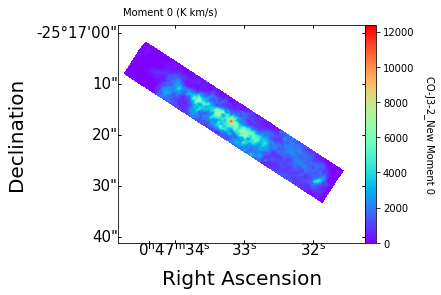

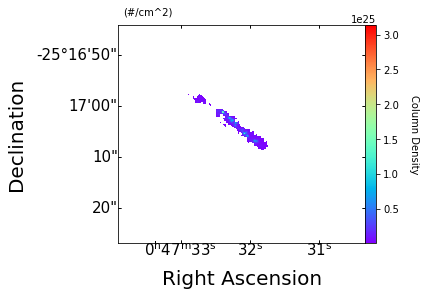

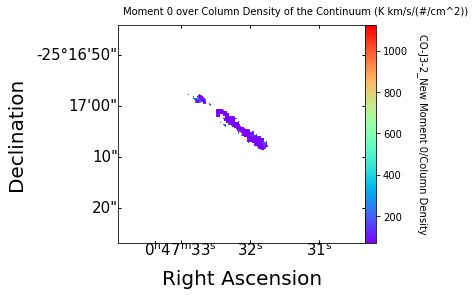

0.49933705924193506

3.5999999999999907e-13 <class 'float'>
0.1767984053546538 arcsec 0.1767984053546538 arcsec
28.327250000000006 pix2
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 0.03535968 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.03535968 arcsec / pix>, 'beam_major': <Quantity 0.17679841 arcsec>, 'beam_minor': <Quantity 0.17679841 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 9.82213363e-06 deg>, 'velocity_scale': <Quantity 2.5 km / s>, 'vaxis': 0}
1440.7917579089974
(4885,)
(270,) (270,)
[3.23175175 0.74308811] [[ 2.49225164e-03 -3.58907498e-04]
 [-3.58907498e-04  6.44753138e-05]] Size Linewidth No Trunks:
a =  3.231751745352507 +- 0.049922456305400924
b =  0.7430881136981937 +- 0.008029652158474771
[3.23175175 0.74308811] [[ 2.49225164e-03 -3.58907498e-04]
 [-3.58907498e-04  6.44753138e-05]] Size Linewidth All_structures:

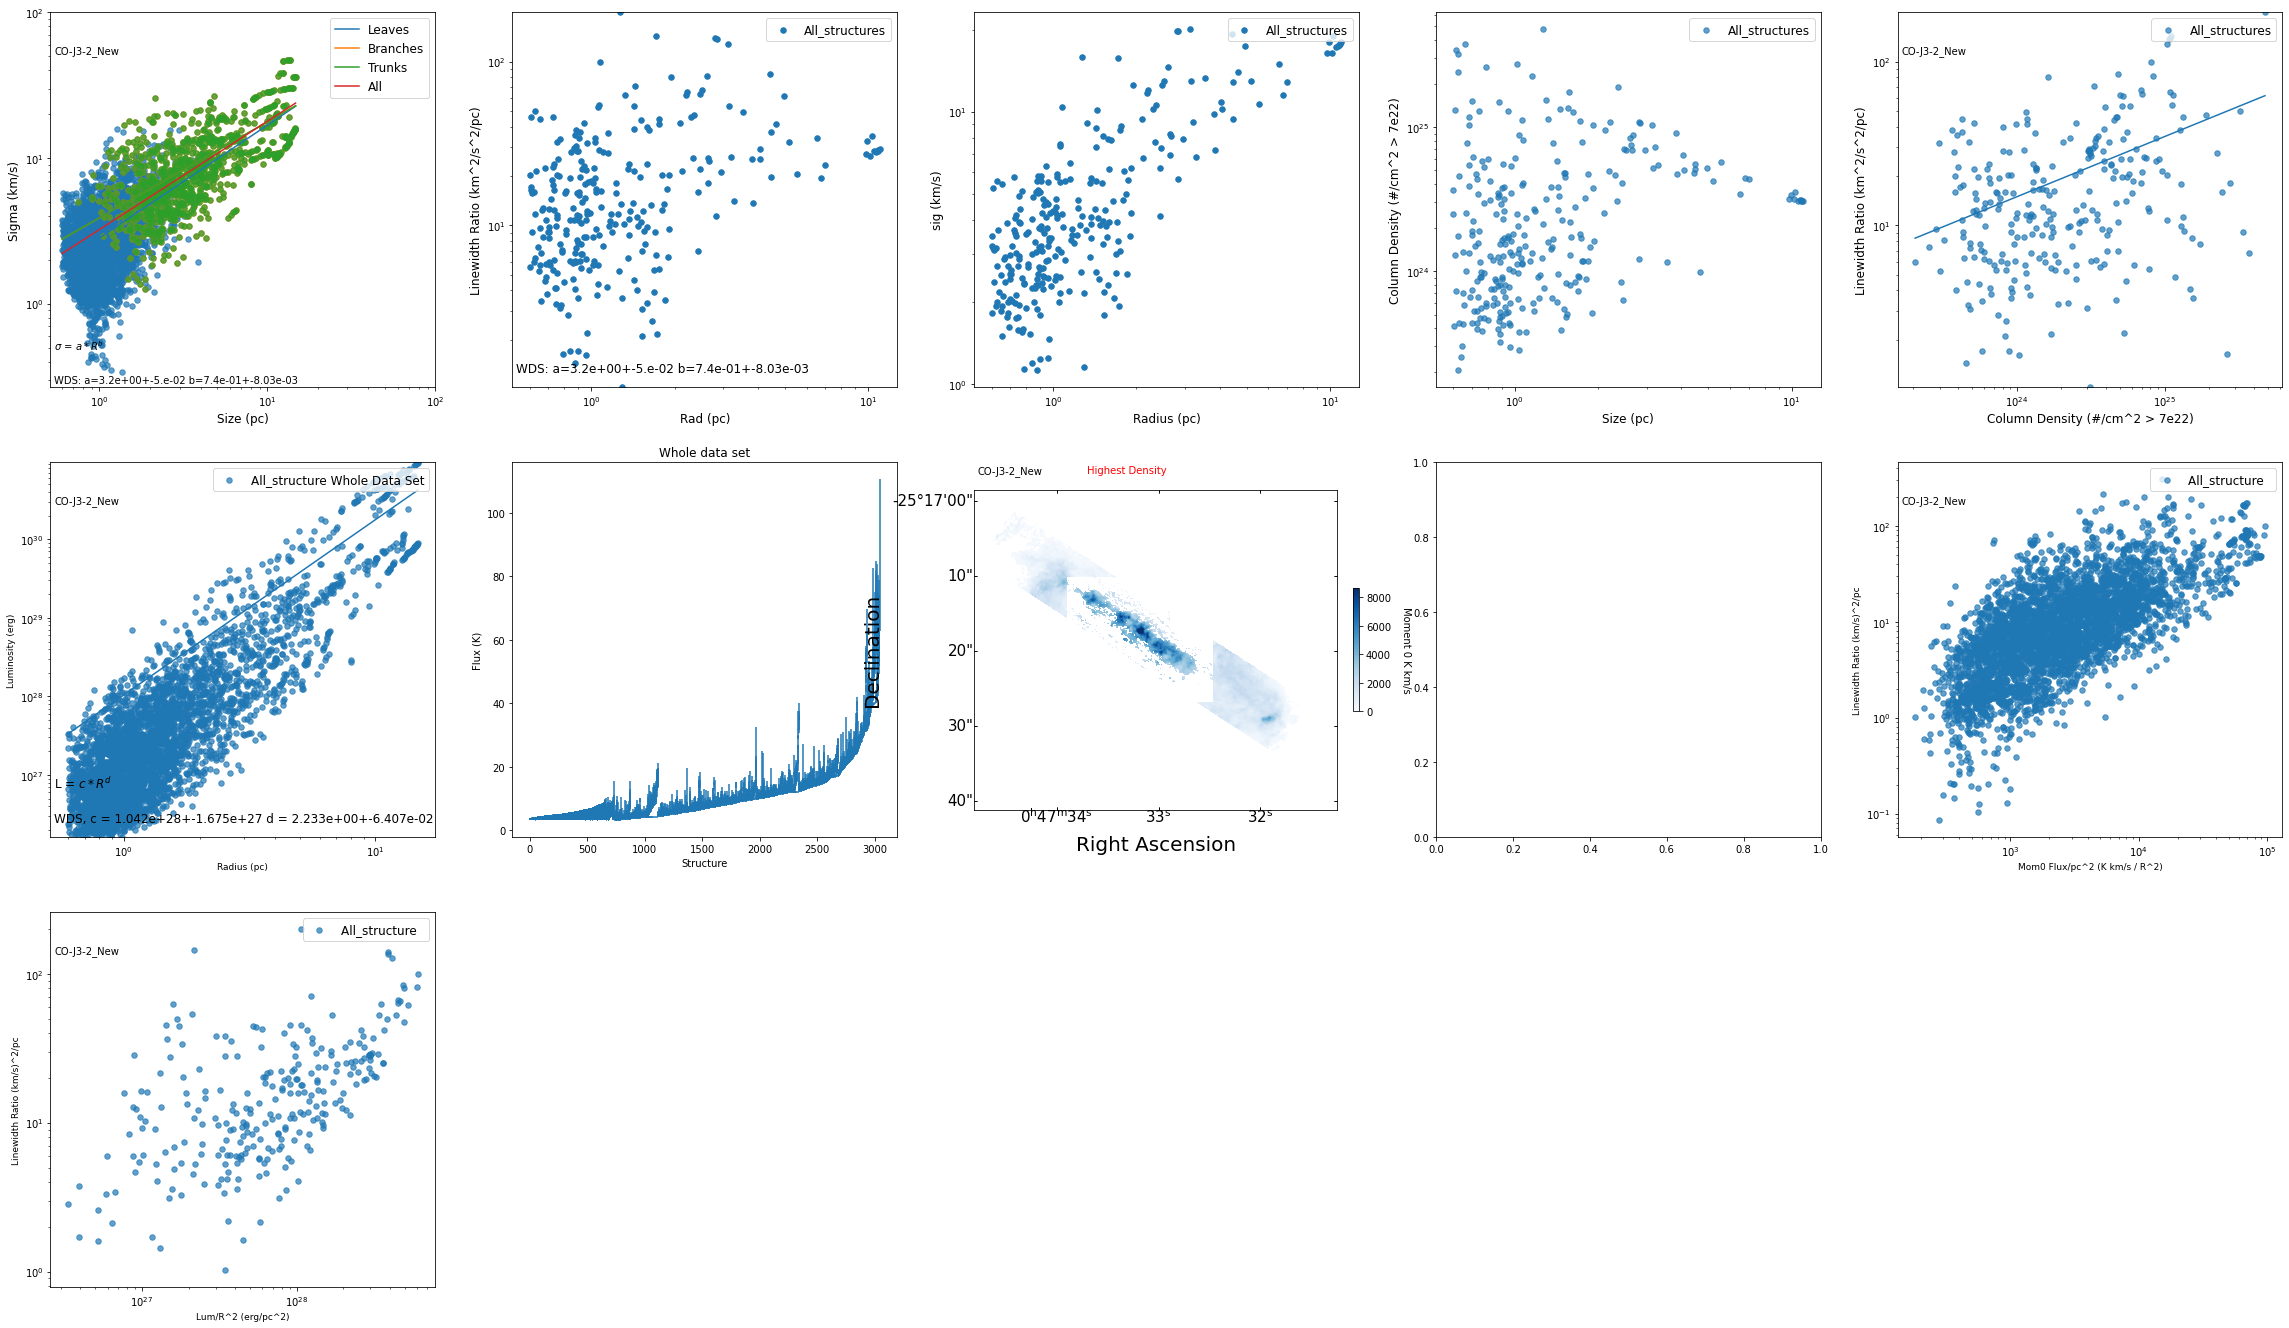

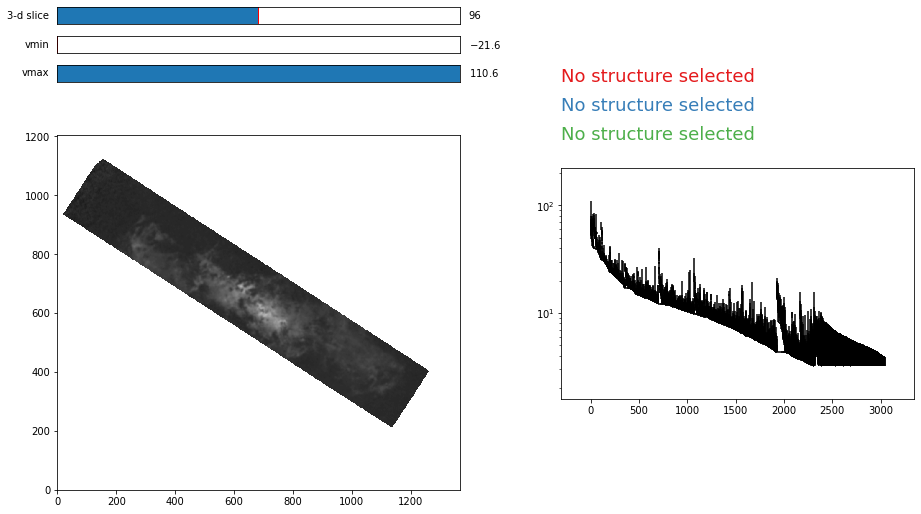

[5140. 5264.]


In [3]:

#CO 


Num=4
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New"
Name = "CO 3-2_Abs_New"
name = "CO_3_2_CM_Contours_DS_10_Abs_New.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

try:
    Names=np.load("Names_New.npy")
except:
    Names=np.load("Names.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_140x800pc.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,:,0:1370]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,:,0:1370]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#scF = scn[:,400:700,600:800]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:800]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False
m = (np.nanstd(scF.hdu.data[0,:,:])) #Noise K

print(m,"Unmatched Noise (K)")
#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

metadata["vaxis"]=0

#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)

##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]

poptTrunk, pcovTrunk = curve_fit(func,  Rads[2]*10**6,Sigmas[2])
try:
    poptTrunk, pcovTrunk = curve_fit(func,  Rads[2]*10**6,Sigmas[2])
except:
    poptTrunk, pcovTrunk = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1],Rads[2]))

Scon = np.concatenate((Sigmas[0],Sigmas[1],Sigmas[2]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon,ysTrunk=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1]),func(xs,poptTrunk[0],poptTrunk[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))



#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)

lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
print(np.shape(cgp),np.shape(rgp))
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth No Trunks:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptTrunk[0],"+-",np.sqrt(pcovTrunk[0][0]))
print("b = ",poptTrunk[1],"+-",np.sqrt(pcovTrunk[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

#xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
xpconL = ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30,alpha=.7)
xpconB = ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30,alpha=.7)
xpconTr = ax2.scatter(Rads[2]*10**6,Sigmas[2],s=30,alpha=.7)


#p = ax2.plot(xs,ysCon)

p = ax2.plot(xs,ysL,label="Leaves")
p = ax2.plot(xs,ysB,label="Branches")
p = ax2.plot(xs,ysTrunk,label="Trunks")
p = ax2.plot(xs,ysCon ,label="All")



st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(0,100)
ax2.set_xlim(0,100)
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()


#Must use text because np load is broken
np.savetxt(NameCol+"_Leaves", CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches", CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves", Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches", Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves", Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches", Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves", Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches", Rads[1],fmt='%s')
np.savetxt(NameFlux, mom0FORFlux/radgpFORFlux**2,fmt='%s')
np.savetxt(NameRFF, rgpFORFlux,fmt='%s')

SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])